## 1. import necessary library

In [96]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import math
import numpy as np
import pandas as pd
from numpy.lib.stride_tricks import as_strided
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Input
import matplotlib.pyplot as plt

## 2. Data Loading Functions

In [97]:
def load_data2(filename, min_date='2010-01-4', max_date='2021-11-30'):
    df = pd.read_csv(filename)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    df = df[min_date:max_date]
    return df

def load_data(filename):
    df = pd.read_csv(filename)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    return df

## 3. Data Preprocessing
### preprocess_data: Extracts specific column data (default is 'Close' prices), scales this data to a range of 0 to 1 using MinMaxScaler. This normalization helps in training neural networks more efficiently.

In [98]:
def preprocess_data(df, column='Close'):
    data_close = df.filter([column])
    data_set = data_close.values
    scaler = MinMaxScaler(feature_range=(0, 1))
    transformed_data = scaler.fit_transform(data_set)
    return transformed_data, scaler

## 4. Training and Testing Data Preparation
### create_train_test_data: Creates training and testing datasets suitable for time series forecasting with LSTM. It involves creating sequences of the past 'look_back' days to predict the next day. This is crucial for capturing temporal dependencies in the data.

In [99]:
def create_train_test_data(transformed_data, data_set, train_data_len, look_back=60):
    # Helper function to create a 3D array for LSTM input from 2D array
    def create_dataset(data, look_back):
        shape = (data.shape[0] - look_back, look_back, data.shape[-1])
        strides = (data.strides[0], data.strides[0], data.strides[-1])
        return as_strided(data, shape=shape, strides=strides)

    # Prepare training data
    train_data = transformed_data[:train_data_len, :]
    x_train = create_dataset(train_data, look_back)
    y_train = train_data[look_back:, 0]

    # Prepare test data
    test_data = transformed_data[train_data_len - look_back:, :]
    x_test = create_dataset(test_data, look_back)
    y_test = data_set[train_data_len:]

    return x_train, y_train, x_test, y_test

## 5. Model Building, Training, and Evaluation
### build_model: Constructs a Sequential LSTM model suitable for time series prediction.
### train_model: Fits the LSTM model to the training data.
### predict_and_evaluate: Uses the trained model to make predictions on the test set and evaluates these predictions using the Root Mean Square Error (RMSE) metric.

In [100]:
def build_model(input_shape, neurons=42, optimizer_type='adam', loss_type='mean_squared_error'):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(neurons, return_sequences=True),
        LSTM(neurons, return_sequences=False),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer=optimizer_type, loss=loss_type)
    return model


In [101]:
def train_model(model, x_train, y_train, num_batch=1, num_epochs=1):
    model.fit(x_train, y_train, batch_size=num_batch, epochs=num_epochs)
    return model

In [102]:
def predict_and_evaluate(model, x_test, y_test, scaler):
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)
    rmse = np.sqrt(np.mean(predictions - y_test) ** 2)
    return predictions, rmse

# 6. Plotting Predictions
## plot_predictions: Plots the historical training data, validation data, and the model's predictions to visually assess how well the model is performing.

In [103]:
def plot_predictions(train, valid, filename):
    plt.figure(figsize=(16, 10))
    plt.title(filename + ' prediction')
    plt.xlabel('Date (year)', fontsize=18)
    plt.ylabel('Close Price $', fontsize=18)
    plt.plot(train['Close'])
    plt.plot(valid[['Close', 'Predictions']])
    plt.legend(['Train', 'Validation', 'Predictions'], loc='upper left')
    plt.show()


## 7. Full Model Execution
### LSTM_Model_Stock_Prediction: function that integrates everything together

In [104]:
def LSTM_Model_Stock_Prediction(filename, neurons=42, optimizer_type='adam', loss_type='mean_squared_error', num_batch=1,
                       num_epochs=1, look_back=60, train_split_size = 0.8):
    df = load_data2(filename, min_date='2016-01-01')
    
    transformed_data, scaler = preprocess_data(df)
    train_data_len = math.ceil(len(transformed_data) * train_split_size)
    data_close = df.filter(['Close'])

    x_train, y_train, x_test, y_test = create_train_test_data(transformed_data, df.filter(['Close']).values, train_data_len,
                                                              look_back=look_back)
    model = build_model((x_train.shape[1], 1), neurons=neurons, optimizer_type=optimizer_type, loss_type=loss_type)
    model = train_model(model, x_train, y_train, num_batch=num_batch, num_epochs=num_epochs)

    predictions, rmse = predict_and_evaluate(model, x_test, y_test, scaler)
    train = data_close[:train_data_len]
    valid = data_close[train_data_len:].copy()
    valid.loc[:, 'Predictions'] = predictions
    plot_predictions(train, valid, filename)
    print(filename, 'RMSE:', rmse)
    # print(valid)

In [105]:
file_name = [
    'data/GOOG.csv',
    'data/AAPL.csv',
    'data/AMZN.csv',
    'data/BABA.csv',
    'data/CRM.csv',
    'data/FB.csv',
    'data/INTC.csv',
    'data/NVDA.csv',
    'data/TSLA.csv'
]
days_back = [2, 4, 8, 16, 32, 64, 128, 256, 512]

optimizer = ['SGD', 'rmsprop', 'adam', 'adamW', 'adadelta', 'adamax', 'adafactor', 'nadam', 'ftrl', 'lion']


1057/1057 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0013
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


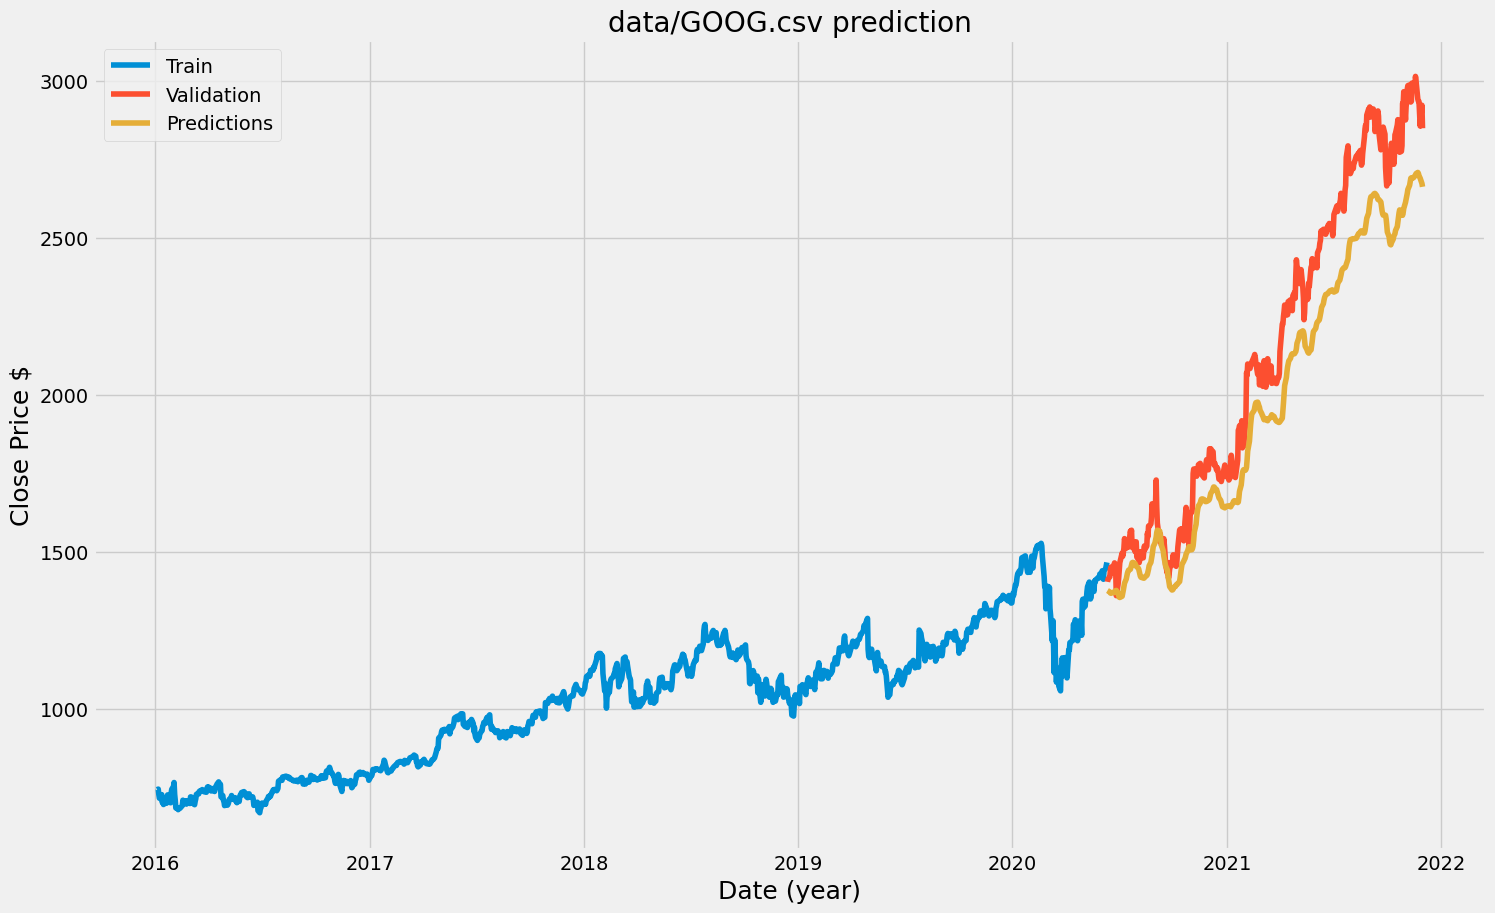

data/GOOG.csv RMSE: 165.83443757123655


In [106]:
# for i in range(len(days_back)):
#     LSTM_predict_stock(
#         file_name[7],
#         neruons=42,
#         optimizer_type='adam',
#         loss_type='mean_squared_error',
#         num_batch=1,
#         num_epochs=1,
#         look_back=days_back[i]
#     )

try:
    LSTM_Model_Stock_Prediction(
        file_name[0],
        neurons=42,
        optimizer_type='adamW',
        loss_type='mean_squared_error',  # the difference between predicted value and actual value
        num_batch=1,  # number of time algo runs on the entire training set
        num_epochs=1,  # number of samples to take to update model parameter
        look_back=60,  
        train_split_size = 0.75  # split between training set and testing set
    )
except Exception as e:
    pass
# for i in range(len(file_name)):
#     try:
#         LSTM_Model_Stock_Prediction(
#             file_name[i],
#             neurons=42,
#             optimizer_type='rmsprop',
#             loss_type='mean_squared_error',  # the difference between predicted value and actual value
#             num_batch=1,  # number of time algo runs on the entire training set
#             num_epochs=1,  # number of samples to take to update model parameter
#             look_back=60,
#             train_split_size = 0.75  # split between training set and testing set
#         )
#     except Exception as e:
#         pass

